# Multivariate Linear Regression

In this notebook we will look at **Multivariate Linear Regression** which seeks to fit the model

$$y=w_0+w_1x_1+...+w_Dx_D$$

where $(x_1,...,x_D)^T$ is the *feature vector*, $\hat{y}$ is the *target value* and $(w_0,...,w_D)^T$ is the *weight vector* formed of parameters of the regression model that we seek to find.

We will first investigate how it is implemented in `sklearn` and implement it ourselves in `numpy`. Then we will look at measuring the performance of regression methods and investigate how dimension of the feature vector influences the performance of the linear regression.

## Dataset

<img src="pictures/BrainVolumes.png" width = "500" style="float: right;"> 
The biomedical application that we will investigate in this notebook is prediction of gestational age (GA) at scan from volumes of brain structures. The brain volumes come from the **Developing Human Connectomme Project** (dHCP, www.developingconnectome.org). We will use three different feature vectors:
* **Whole brain volume - a single feature** 
* **Main brain structures - six features:** cortical gray matter, cortical white matter, myelinated subcortical white matter, subcortical gray matter, cerebellum and brainstem. 
* **All dHCP brain structures - 86 features** 

The segmentations were performed using dHCP processing pipeline (www.doi.org/10.1016/j.neuroimage.2018.01.054). The software is available for download here: www.github.com/MIRTK/DrawEM. The list of all labels is available here:www.github.com/MIRTK/DrawEM/blob/master/label_names/all_labels.csv. Please note we have excluded label 84. 

This notebook accompanies the **Part I and II** of the Lecture 3 **Regression**. 

## Multivariate Linear Regression in Scikit-learn

### Load the dataset

We will first explore the multivariate linear regression using the dataset with 6 brain volumes for prediction of GA at scan. 

The code bellow loads the dataset, extract the feature matrix and the target vector, and scales the features using `StandardScaler`. This is implemented in the function `CreateFeaturesTargets`, which accepts a 'csv' file as an input and returns extracted feature matrix `X` that contains the volumes and target vector `y`with GA. 


__Activity 1:__ Fill in the code to print out the numbers of sample and features and run the cell. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def CreateFeaturesTargets(filename):
    
    df = pd.read_csv(filename,header=None)
    
    # convert from 'DataFrame' to numpy array
    data = df.values

    # Features are in columns one to end
    X = data[:,1:]
    
    # Scale features
    X = StandardScaler().fit_transform(X)

    # Labels are in the column zero
    y = data[:,0]

    # return Features and Labels
    return X, y

X,y = CreateFeaturesTargets('datasets/GA-brain-volumes-6-features.csv')

print('Number of samples is', X.shape[0])
print('Number of features is', X.shape[1])
print('Number of targets is', y.shape[0])

Number of samples is 164
Number of features is 6
Number of targets is 164


### Visualise the dataset
Run the code bellow to visualise individual features of this dataset

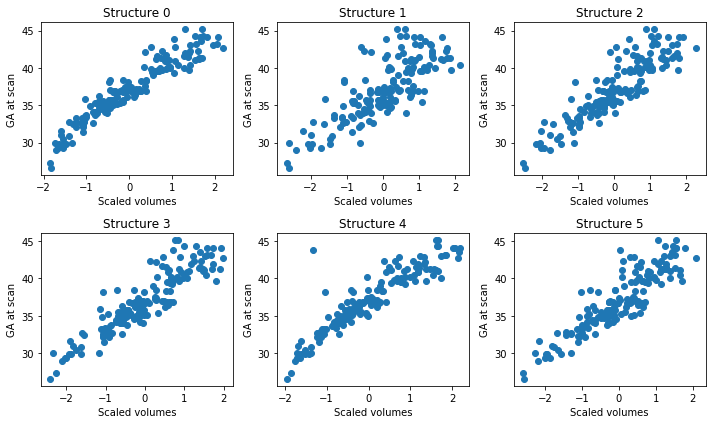

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10,6))

for i in range(6):
        plt.subplot(2,3,i+1)
        plt.scatter(X[:,i], y)
        plt.xlabel('Scaled volumes')
        plt.ylabel('GA at scan')
        plt.title('Structure '+ str(i))
    
plt.tight_layout()

### Fit model using normal equation

The code bellow fits the `LinearRegression` model to the data using **normal equation**. The performance is evaluated using the **Root Mean Squared Error** (RMSE). This is done first on the whole dataset using function `mean_squared_error` and then using cross-validation implemented by a sklearn function `cross_val_score`. Run the code. 

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Choose the linear regression model
model = LinearRegression()

# Calculate RMSE on the whole set
model.fit(X,y)
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print('RMSE: {} weeks'.format(round(rmse,2)))

# Calculate RMSE using cross-validation
scores = cross_val_score(model,X,y, scoring='neg_mean_squared_error',cv=5)
rmse_cv = np.sqrt(-np.mean(scores))
print('RMSE_CV: {} weeks'.format(round(rmse_cv,2)))

RMSE: 1.12 weeks
RMSE_CV: 1.27 weeks


**Activity 2:** Notice the RMSE. In which units is it? We calculate RMSE on the whole dataset and using cross-validation. Which one is larger? We will later compare these errors to other regression methods.

**Answer:** The RMSE is in weeks and represents the average error in estimated age of the baby.

### Fit model using SGD
We will now fit the model multivariate linear regression model using **stochastic gradient descent** implemented in `SGDRegressor`.

**Activity 3:** In the previous cell you have seen how to calculate RMSE. Complete the functions
* `RMSE` to calculate RMSE on the whole dataset
* `RMSE_CV` to calculate cross-validated RMSE 

Run the code and compare the error to the fit using normal equation, that we have perfored before.

In [4]:
def RMSE(model,X,y):
    model.fit(X,y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print('RMSE: {} weeks'.format(round(rmse,2)))
    return rmse

def RMSE_CV(model,X,y):
    scores = cross_val_score(model,X,y, scoring='neg_mean_squared_error',cv=5)
    rmse_cv = np.sqrt(-np.mean(scores))
    print('RMSE_CV: {} weeks'.format(round(rmse_cv,2)))
    return rmse_cv


from sklearn.linear_model import SGDRegressor

model = SGDRegressor(loss="squared_loss", penalty=None)
rmse = RMSE(model,X,y)
rmse_cv = RMSE_CV(model,X,y)

RMSE: 1.17 weeks
RMSE_CV: 1.32 weeks


## Exercise 1: Normal equation in Numpy

Implement multivariate linear regression using the **normal equation** in `numpy`. Do __not__ use any `sklearn` functions.

Perform the following steps:
* Split the dataset into training and test set, by including the first 120 samples in the training set and the rest in the test set 
* Implement fitting of the model to the training data in `numpy` using $\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$
* Predict the target values on the test according to $\mathbf{\hat{y}}=\mathbf{Xw}$
* Calculate the RMSE on the test set using $RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2}$

You will need these `numpy` functions:
* `np.hstack` to concatenate two numpy arrays
* `np.matmul` performs matrix multiplication
* `matrix.T` transposes the `matrix`
* `np.linalg.inv` inverts a matrix

Some of the code has been provided for you, fill in the missing commands. You can refer to the Part I of lecture to help you complete this exercise.

In [5]:
# Create a column of ones
x0 = np.ones([X.shape[0],1])

# Concatenate with the feature matrix to add feature zero
X1 = np.hstack([x0,X])

# Print the first three lines of the new feature matrix
print(np.around(X1[:3,:],2))

# Print the new number of features
print('\n The new number of features is ', X1.shape[1])

[[ 1.   -0.48 -0.11 -0.31 -0.42 -0.43 -0.32]
 [ 1.   -0.11  0.03 -0.06 -0.18  0.02  0.  ]
 [ 1.   -0.29  0.01 -0.15 -0.24 -0.24 -0.14]]

 The new number of features is  7


In [6]:
# Split into training and test set
X1_train = X1[:120,:]
y_train = y[:120]
X1_test = X1[120:,:]
y_test = y[120:]
print('Number of samples in train {} and test {}'.format(X1_train.shape[0],X1_test.shape[0]))

Number of samples in train 120 and test 44


In [7]:
# Implement equation w=(XtX)^-1 * Xty
XtX = np.matmul(X1_train.T,X1_train)
Xty = np.matmul(X1_train.T,y_train)
w = np.matmul(np.linalg.inv(XtX),Xty)
print('Coeffs:',np.around(w,2))

Coeffs: [37.17  3.95 -1.1  -0.2  -0.43  1.11  0.08]


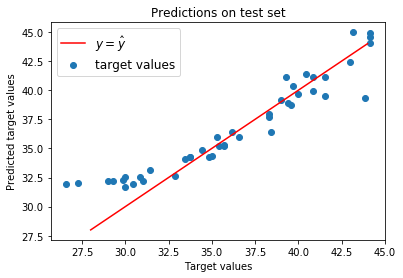

In [8]:
# predict on test set
y_pred_test = np.matmul(X1_test,w)

# plot predicted against expected target values
plt.scatter(y_test,y_pred_test, label = 'target values')
plt.plot([28,44],[28,44],'r', label = '$y=\hat{y}$')
plt.title('Predictions on test set')
plt.xlabel('Target values')
plt.ylabel('Predicted target values')
_=plt.legend(fontsize = 12)

In [9]:
# calculate RMSE on test set
rmse = np.sqrt(np.mean((y_test-y_pred_test)**2))
print('RMSE test: {} weeks'.format(round(rmse,2)))

RMSE test: 1.78 weeks


## Exercise 2: Compare performance of linear regression models with different numbers of features 

In this exercise we will compare performance of multivariate linear regression models with different numbers of features to predidict age of a baby.

First we will now load the datasets and print out number of features. Run the code.

In [10]:
# Load the datasets. Target values y  are the same for all datasets
X1,y = CreateFeaturesTargets('datasets/GA-brain-volumes-1-feature.csv')
print('Number of features in X1 is ', X1.shape[1])
X6,y = CreateFeaturesTargets('datasets/GA-brain-volumes-6-features.csv')
print('Number of features in X6 is ', X6.shape[1])
X86,y = CreateFeaturesTargets('datasets/GA-brain-volumes-86-features.csv')
print('Number of features in X86 is ', X86.shape[1])

Number of features in X1 is  1
Number of features in X6 is  6
Number of features in X86 is  86


In the next step we will create a linear regression model and calculate RMSE on the whole set. Use the function `RMSE` that we have created previously. Fill in the code bellow and run it.

In [11]:
# Select the model
model = LinearRegression()

# Single feature
print('Single feature:')
rmse1 = RMSE(model,X1,y)

# 6 features
print('Six features:')
rmse6 = RMSE(model,X6,y)

# 86 features
print('86 features:')
rmse86 = RMSE(model,X86,y)

Single feature:
RMSE: 1.56 weeks
Six features:
RMSE: 1.12 weeks
86 features:
RMSE: 0.69 weeks


What happens with RMSE on the whole set as we increase the number of features? Can you interpret this behaviour?

__Answer:__ RMSE increases with increasing number of features. This can be due to improvement of the fit but also due to overfitting. To recognise the overfitting we need to calculate RMSE using cross-validatation.

Now let's calculate the cross-validated RMSE for the three different feature matrices. You can use function `RMSE_CV` that we created before to calculate and print out the scores.

In [12]:
# Single feature
print('Single feature:')
rmse_cv1 = RMSE_CV(model,X1,y)

# 6 features
print('Six features:')
rmse_cv6 = RMSE_CV(model,X6,y)

# 86 features
print('86 features:')
rmse_cv86 = RMSE_CV(model,X86,y)

Single feature:
RMSE_CV: 1.6 weeks
Six features:
RMSE_CV: 1.27 weeks
86 features:
RMSE_CV: 2.08 weeks


Which model performs the best? Which model is overfitted? 

__Answer:__ The model with 6 features performs the best, because it has the lowest RMSE_CV=1.27. The model with 86 features has RMSE=0.69 and RMSE_CV=2.08 which is a big difference and it is therefore clearly overfitted.